In [95]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.svm import LinearSVR
from sklearn.metrics import r2_score
from sklearn.ensemble import StackingRegressor
from sklearn.feature_selection import RFECV
from xgboost.sklearn import XGBClassifier

data = pd.ExcelFile('Data.xlsx')
plants = pd.read_excel(data, 'plants')
flight = pd.read_excel(data, 'flight dates')
planting = pd.read_excel(data, 'planting')
weather = pd.read_excel(data, 'weather')

ModuleNotFoundError: No module named 'xgboost'

In [2]:
    # Renaming the plants data columns
plants = plants.rename(columns = {'Batch Number': 'batch_number', 'Plant Date': 'plant_date', 'Class': 'class', 
                                'Fresh Weight (g)': 'fresh_weight', 'Head Weight (g)': 'head_weight', 
                                'Radial Diameter (mm)': 'radial_diameter', 'Polar Diameter (mm)': 'polar_diameter', 
                                'Diameter Ratio': 'diameter_ratio', 'Leaves': 'leaves', 'Density (kg/L)': 'density',
                                'Leaf Area (cm^2)': 'leaf_area', 'Square ID': 'square_id', 
                                'Check Date': 'check_date', 'Flight Date': 'flight_date', 'Remove': 'remove'})
plants.describe()


,batch_number,class,fresh_weight,head_weight,radial_diameter,polar_diameter,diameter_ratio,leaves,density,leaf_area,square_id
count,4859.000000,4859.000000,4858.000000,4754.000000,4754.000000,4754.000000,4752.000000,100.000000,4672.000000,4857.000000,4859.000000
mean,621.778349,2.973040,469.627755,183.349811,99.316996,96.546277,1.037744,17.070000,21.730421,495.275067,403.202099
std,92.932427,1.422882,295.819075,187.242036,42.708981,34.909629,1.881858,28.063512,449.793088,212.659323,416.029674
min,402.000000,1.000000,0.632000,0.000000,0.000000,0.000000,0.050000,7.000000,0.014551,25.000000,4.000000
25%,542.000000,2.000000,229.250000,28.000000,65.000000,70.000000,0.900000,8.000000,0.160685,337.000000,94.000000
50%,647.000000,3.000000,426.000000,115.000000,109.000000,100.000000,1.023859,9.500000,0.216925,471.000000,247.000000
75%,698.000000,4.000000,677.000000,304.000000,135.000000,125.000000,1.142857,12.500000,0.293362,620.000000,529.000000
max,739.000000,5.000000,1978.000000,998.000000,185.000000,200.000000,128.000000,160.000000,19671.550966,1305.000000,2019.000000


In [3]:
# Dropping the wrong garbage data after row 1822 
planting = planting.iloc[0:1821, :]
planting = planting.drop(columns = ['Column2', 'Column3', 'Column1', 'Column4'])
planting

,Crop,Plant_Date,Region,Planting_Batch,Volume_Planted,Planting_Wk
0,3,2020-02-06 00:00:00,0.0,392,198912.0,6.0
1,3,2020-02-07 00:00:00,0.0,503,63840.0,6.0
2,3,2020-02-07 00:00:00,0.0,614,179928.0,6.0
3,3,2020-02-08 00:00:00,0.0,725,200256.0,6.0
4,3,2020-02-10 00:00:00,0.0,770,13944.0,7.0
...,...,...,...,...,...,...
1816,1,2020-08-12 00:00:00,1.0,158,142500.0,33.0
1817,1,2020-08-21 00:00:00,1.0,388,98208.0,34.0
1818,1,2020-08-25 00:00:00,1.0,390,256358.0,35.0
1819,1,2020-08-27 00:00:00,1.0,389,85500.0,35.0


In [4]:
# Removing all the non-null values from the 'Remove column'
plants = plants[plants['remove'].isnull()]

# Dropping the remove column from the dataset
plants = plants.drop(columns = ['remove'])

# Dropping the leaves column
plants = plants.drop(columns = ['leaves'])

In [5]:
# the number of NaN values in the plants plant_date
plants['plant_date'].isna().sum()

174

In [6]:
# rename the flights data columns
flight = flight.rename(columns = {'Batch Number': 'batch_number', 'Flight Date': 'flight_date'})

In [7]:
# Merging the plants and flight data on 'batch_number'
df_merge = pd.merge(plants, flight, how = 'left', on = 'batch_number')
dd1 = df_merge.loc[: , df_merge.columns != 'flight_date_x']
dd2 = df_merge.drop('flight_date_y', axis = 1)

dd1 = dd1.rename(columns = {'flight_date_y': 'flight_date'})
dd2 = dd2.rename(columns = {'flight_date_x': 'flight_date'})

dd1.update(dd2)
df_merge = dd1

In [8]:
### Dropping the NaN values of the flight_date, head_weight, radial_diameter, polar_diameter
plant = df_merge.dropna(subset = ['flight_date', 'head_weight', 'radial_diameter', 'polar_diameter'])

In [9]:
plant = plant.copy()

In [10]:
plant

,batch_number,plant_date,class,fresh_weight,head_weight,radial_diameter,polar_diameter,diameter_ratio,density,leaf_area,square_id,check_date,flight_date
75,402,2020-04-11,2,213.0,13.0,55.0,55.0,1.000000,0.149230,730.0,570,2020-05-22,2020-04-30
76,402,2020-04-11,5,179.0,10.0,40.0,40.0,1.000000,0.298416,643.0,570,2020-05-22,2020-04-30
77,402,2020-04-11,5,183.0,13.0,50.0,50.0,1.000000,0.198625,647.0,570,2020-05-22,2020-04-30
78,402,2020-04-11,3,176.0,7.0,40.0,40.0,1.000000,0.208891,694.0,570,2020-05-22,2020-04-30
79,402,2020-04-11,1,192.0,22.0,70.0,70.0,1.000000,0.122498,730.0,570,2020-05-22,2020-04-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3773,693,NaT,4,621.0,188.0,120.0,85.0,1.411765,0.293344,780.0,85,2020-09-25,2020-09-10
3774,693,NaT,1,680.0,273.0,120.0,90.0,1.333333,0.402308,834.0,85,2020-09-25,2020-09-10
3775,693,NaT,2,583.0,203.0,115.0,92.0,1.250000,0.318650,726.0,85,2020-09-25,2020-09-10
3776,693,NaT,3,609.0,213.0,120.0,90.0,1.333333,0.313889,769.0,85,2020-09-25,2020-09-10


In [11]:
### dropping the rows with Null values in plant_date
plant.dropna(subset = ['plant_date'], inplace = True)

In [12]:
### Making a new variable 'flight_time' which tells the number of days from the 'plant_date'
plant['flight_time'] = plant['flight_date'] - plant['plant_date']
plant['flight_time'] = plant['flight_time'].astype('timedelta64[D]')

In [13]:
plant['check_time'] = plant['check_date'] - plant['plant_date']
plant['check_time'] = plant['check_time'].astype('timedelta64[D]')

In [14]:
plant['check_flight_time'] = plant['check_date'] - plant['flight_date']
plant['check_flight_time'] = plant['check_flight_time'].astype('timedelta64[D]')

In [15]:
### dropping all the Null values in the plants
plant.dropna(inplace=True)

In [16]:
### changing the plant-date and check-date to date time format
plant['plant_date']= pd.to_datetime(plant['plant_date'])
plant['check_date']= pd.to_datetime(plant['check_date'])


In [17]:
### renaming the columns of the weather data
weather = weather.rename(columns = {'Unnamed: 0': 'weather_date', 'Solar Radiation [avg]': 'solar_radiation', 
                            'Precipitation [sum]': 'precipitation', 'Wind Speed [avg]': 'wind_speed_avg',
                            'Wind Speed [max]': 'wind_speed_max', 'Battery Voltage [last]': 'battery_voltage',
                           'Leaf Wetness [time]': 'leaf_wetness', 'Air Temperature [avg]': 'air_temp_avg',
                           'Air Temperature [max]': 'air_temp_max', 'Air Temperature [min]': 'air_temp_min',
                           'Relative Humidity [avg]': 'relative_humidity', 'Dew Point [avg]': 'dew_point_avg',
                           'Dew Point [min]': 'dew_point_min', 'ET0 [result]': 'eto_result'})

In [18]:
###  dropping the duplpicates in the weather dataset
weather = weather.drop_duplicates(subset = ['weather_date'])

In [19]:
### changing the weather-date to date time format
weather['weather_date']= pd.to_datetime(weather['weather_date'])

In [20]:

for x,(i, j) in enumerate(zip(plant.plant_date, plant.check_date)):
    df_subset = weather[(weather['weather_date']>i) & (weather['weather_date']< j)]
    plant.at[x, 'avg_precipitation'] = (df_subset['precipitation'].mean())
    plant.at[x, 'std_precipitation'] = (df_subset['precipitation'].std())
    plant.at[x, 'avg_solar_rad'] = df_subset['solar_radiation'].mean()
    plant.at[x, 'std_solar_rad'] = df_subset['solar_radiation'].std()
    plant.at[x, 'avg_wind_speed'] = df_subset['wind_speed_avg'].mean()
    plant.at[x, 'std_wind_speed'] = df_subset['wind_speed_avg'].std()
    plant.at[x, 'avg_air_temp'] = df_subset['air_temp_avg'].mean()
    plant.at[x, 'std_air_temp'] = df_subset['air_temp_avg'].std()
    plant.at[x, 'avg_leaf_wetness'] = df_subset['leaf_wetness'].mean()
    plant.at[x, 'std_leaf_wetness'] = df_subset['leaf_wetness'].std()
    plant.at[x, 'avg_relative_humidity'] = df_subset['relative_humidity'].mean()
    plant.at[x, 'std_relative_humidity'] = df_subset['relative_humidity'].std()
    plant.at[x, 'avg_dew_point'] = df_subset['dew_point_avg'].mean()
    plant.at[x, 'std_dew_point'] = df_subset['dew_point_avg'].std()

In [21]:
### dropping the rows with Null values again if any
plant = plant.dropna()

In [22]:
plant = plant[['plant_date', 'flight_date', 'check_date','batch_number', 'class', 'density', 
               'leaf_area','square_id', 
               'flight_time', 'check_time', 'check_flight_time', 
               'avg_precipitation', 'std_precipitation', 'avg_solar_rad', 'std_solar_rad',
               'avg_wind_speed','std_wind_speed', 'avg_air_temp', 'std_air_temp', 
               'avg_leaf_wetness', 'std_leaf_wetness', 'avg_relative_humidity','std_relative_humidity',
               'avg_dew_point','std_dew_point' ,'fresh_weight', 'diameter_ratio',
               'head_weight', 'radial_diameter', 'polar_diameter']]

In [23]:
plant

,plant_date,flight_date,check_date,batch_number,class,density,leaf_area,square_id,flight_time,check_time,...,std_leaf_wetness,avg_relative_humidity,std_relative_humidity,avg_dew_point,std_dew_point,fresh_weight,diameter_ratio,head_weight,radial_diameter,polar_diameter
75,2020-04-11,2020-04-30,2020-05-22,402.0,2.0,0.149230,730.0,570.0,19.0,41.0,...,82.753108,71.723774,8.390447,6.345283,3.118836,213.0,1.00,13.0,55.0,55.0
76,2020-04-11,2020-04-30,2020-05-22,402.0,5.0,0.298416,643.0,570.0,19.0,41.0,...,82.753108,71.723774,8.390447,6.345283,3.118836,179.0,1.00,10.0,40.0,40.0
77,2020-04-11,2020-04-30,2020-05-22,402.0,5.0,0.198625,647.0,570.0,19.0,41.0,...,82.753108,71.723774,8.390447,6.345283,3.118836,183.0,1.00,13.0,50.0,50.0
78,2020-04-11,2020-04-30,2020-05-22,402.0,3.0,0.208891,694.0,570.0,19.0,41.0,...,82.753108,71.723774,8.390447,6.345283,3.118836,176.0,1.00,7.0,40.0,40.0
79,2020-04-11,2020-04-30,2020-05-22,402.0,1.0,0.122498,730.0,570.0,19.0,41.0,...,82.753108,71.723774,8.390447,6.345283,3.118836,192.0,1.00,22.0,70.0,70.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3084,2020-08-08,2020-09-10,2020-09-10,693.0,4.0,0.144413,365.0,238.0,33.0,33.0,...,249.611878,83.912000,8.694714,13.882500,3.486523,67.0,0.92,1.0,23.0,25.0
3085,2020-08-08,2020-09-10,2020-09-10,693.0,2.0,0.159155,368.0,238.0,33.0,33.0,...,249.611878,83.912000,8.694714,13.882500,3.486523,73.0,0.75,3.0,30.0,40.0
3086,2020-08-08,2020-09-10,2020-09-10,693.0,3.0,0.589463,266.0,238.0,33.0,33.0,...,249.611878,83.912000,8.694714,13.882500,3.486523,47.0,0.90,2.0,18.0,20.0
3087,2020-08-08,2020-09-10,2020-09-10,693.0,1.0,0.660851,335.0,238.0,33.0,33.0,...,249.611878,83.912000,8.694714,13.882500,3.486523,37.0,0.85,2.0,17.0,20.0


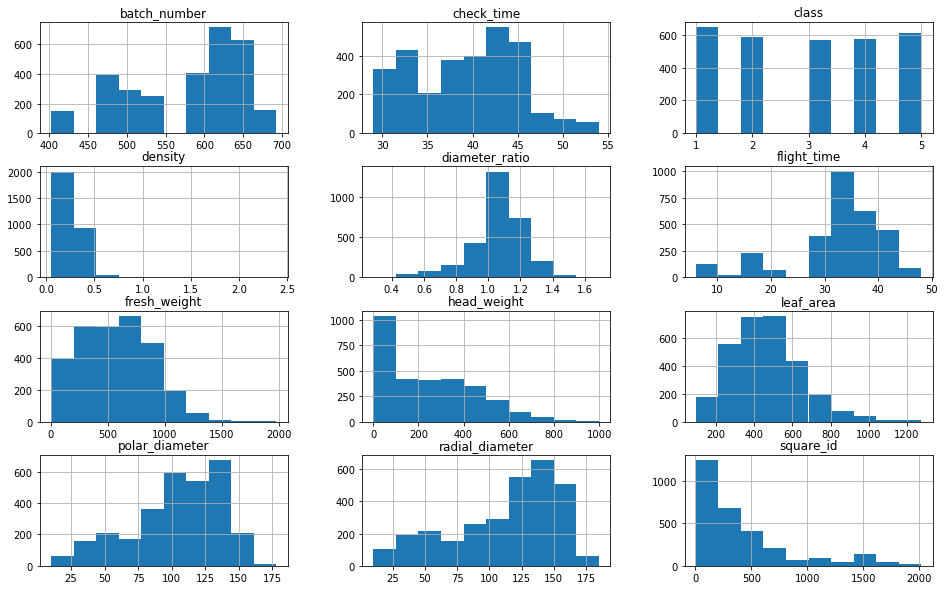

In [97]:
### Exploratory Data Analysis

### Plant data analysis
plant_data = plant[['batch_number', 'class', 
                     'density', 'leaf_area','square_id', 'flight_time', 'check_time' ,'fresh_weight', 
                    'diameter_ratio', 'head_weight', 'radial_diameter', 'polar_diameter']]

plant_data.hist(figsize = (16,10))
plt.savefig("plant_hist.pdf", format="pdf", bbox_inches="tight")
plt.show()


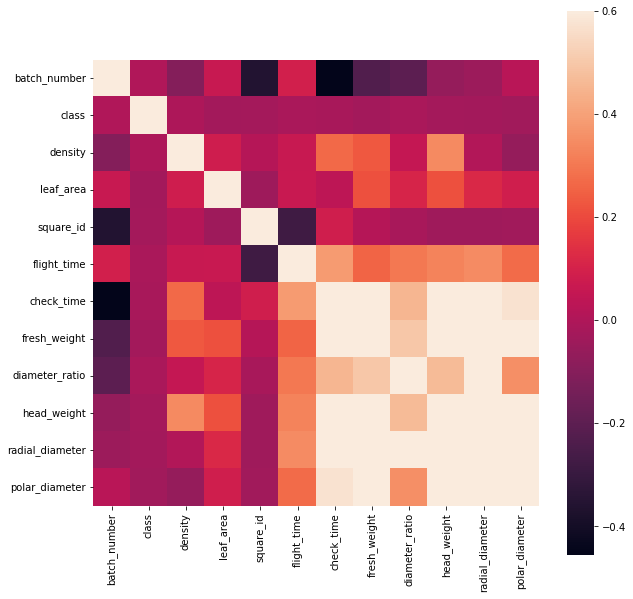

In [98]:
### plant_data heatmap
fig = plt.figure(figsize = (10,10))
sns.heatmap(plant_data.corr(), vmax = 0.6, square = True)
plt.savefig("plant_heatmap.pdf", format="pdf", bbox_inches="tight")
plt.show()


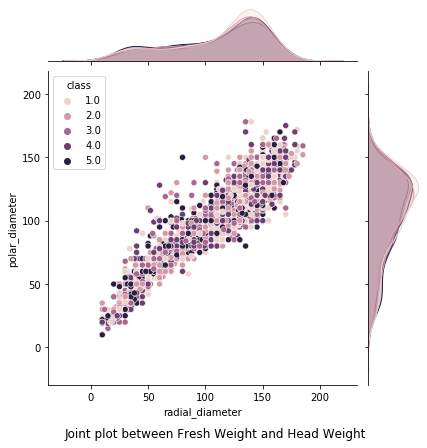

In [106]:
sns.jointplot(x = "radial_diameter",y = "polar_diameter", data=plant, hue="class");
plt.savefig("radial_polar.pdf", format="pdf", bbox_inches="tight")
plt.suptitle("Joint plot between Fresh Weight and Head Weight", y = 0)
plt.show()

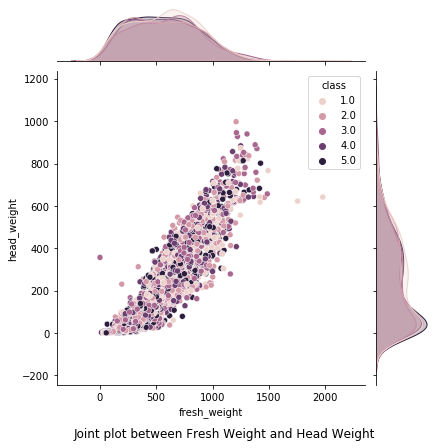

In [107]:
sns.jointplot(x = "fresh_weight", y = "head_weight", data=plant
              , hue="class");
plt.suptitle("Joint plot between Fresh Weight and Head Weight", y = 0)
plt.savefig("fresh_weight_head_weight.pdf", format="pdf", bbox_inches="tight")
plt.show()

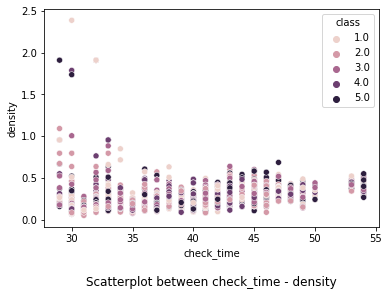

In [108]:
sns.scatterplot(data = plant, x="check_time", y="density", hue="class")
plt.title('Scatterplot between check_time - density',loc='center' ,y=-0.3)
plt.xlabel('check_time')
plt.ylabel('density')
plt.savefig("check_time_density.pdf", format="pdf", bbox_inches="tight")

plt.show()

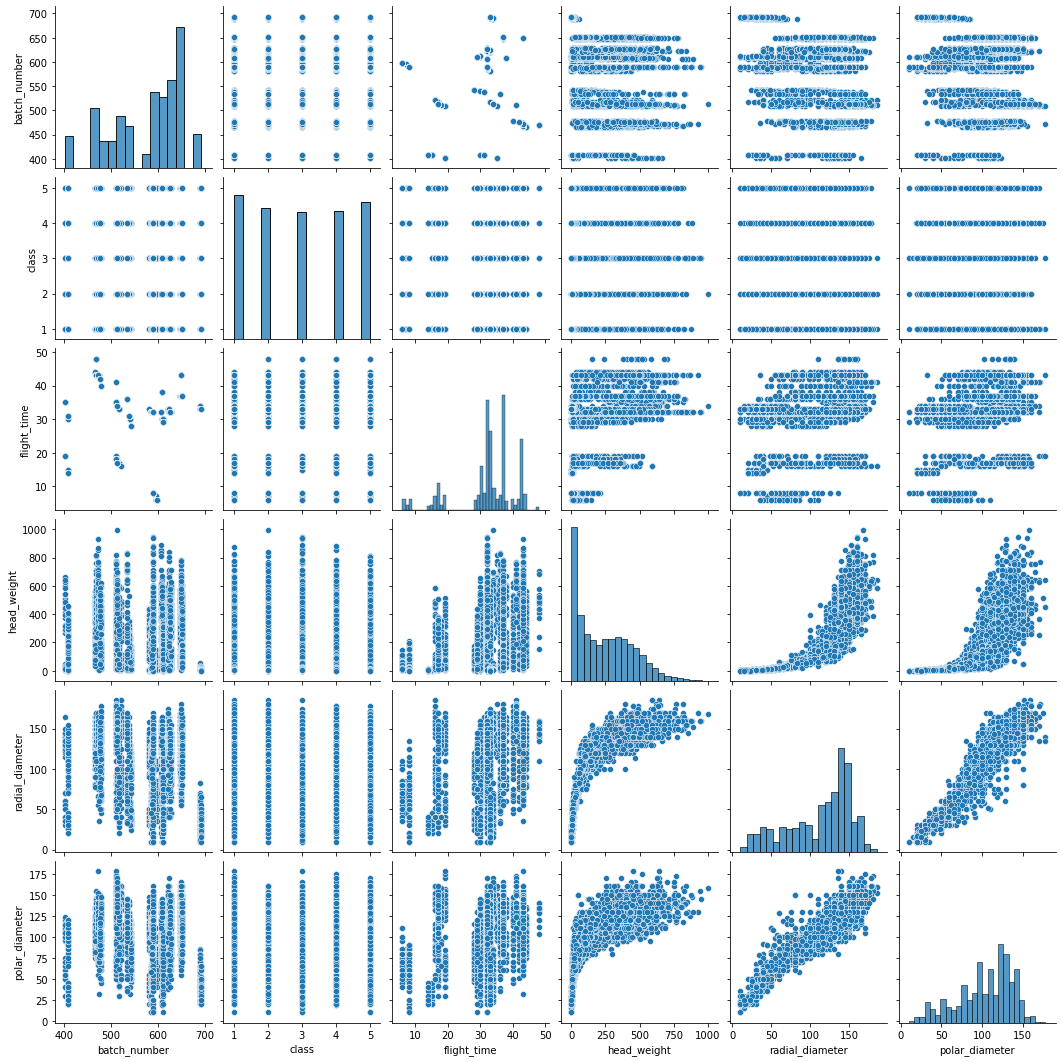

In [109]:
sns.pairplot(plant[['batch_number', 'class', 'flight_time' ,
                     'head_weight', 'radial_diameter', 'polar_diameter']])  

plt.savefig("plant_pairplot.pdf", format="pdf", bbox_inches="tight")
plt.show()

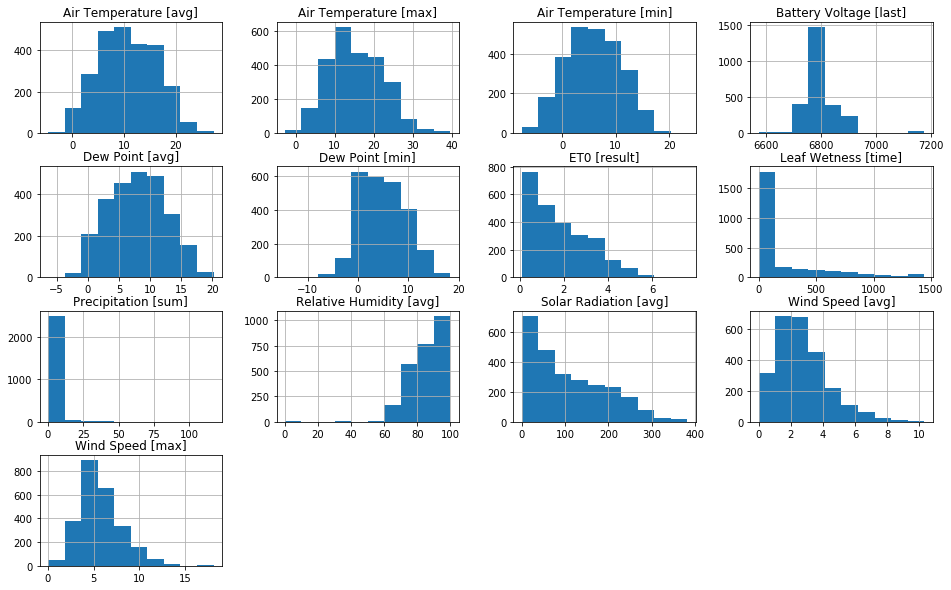

In [110]:
### weather data analysis

weather.hist(figsize = (16,10))
plt.savefig("weather_histplot.pdf", format="pdf", bbox_inches="tight")

plt.show()

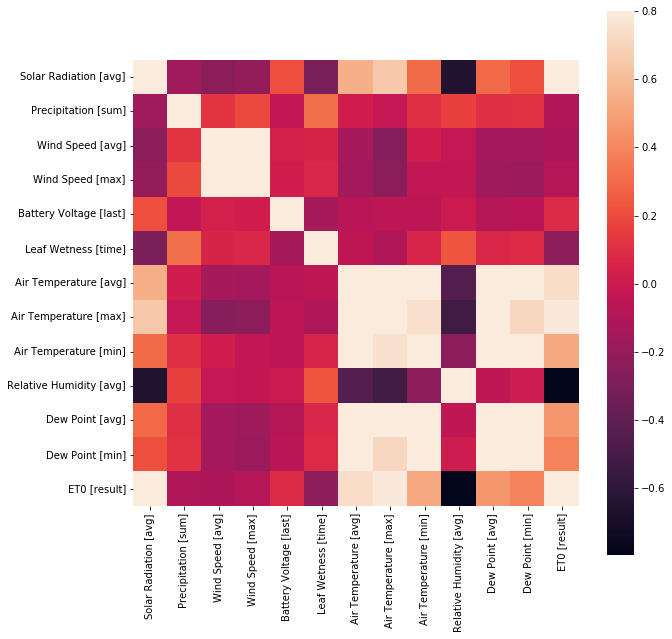

In [111]:
fig = plt.figure(figsize = (10,10))
sns.heatmap(weather.corr(), vmax = .8, square = True)
plt.savefig("weather_heatmap.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [37]:
X = plant.iloc[:, 3:-5]
y = plant.iloc[:, -3:]

In [43]:
X = X.to_numpy()
y = y.to_numpy()

In [45]:
### detection of Outliers
outliers = LocalOutlierFactor()
out = outliers.fit_predict(X)
# masking out by selecting all rows that are not outliers
mask = out != -1
X, y = X[mask, :], y[mask]
print(X.shape, y.shape)

(2953, 22) (2953, 3)


In [47]:
# Split the data into train, test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [127]:
X_plant = plant.iloc[:, 3:11]
y_plant = plant.iloc[:, -3:]
X_weather = plant.iloc[:, 11:25]
y_weather = plant.iloc[:, -3:]

In [128]:
X_plant_train, X_plant_test, y_plant_train, y_plant_test = train_test_split(X_plant, y_plant, test_size=0.33, 
                                                                            random_state=42)
X_weather_train, X_weather_test, y_weather_train, y_weather_test = train_test_split(X_weather, y_weather, 
                                                                                    test_size=0.33, random_state=42)

In [132]:
# Model 1 : Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('model score:' ,r2_score(y_test, y_pred, multioutput='variance_weighted'))

model score: 0.7150600047701142


In [129]:
# Model 1.1 : Linear Regression using just plants data
model = LinearRegression()
model.fit(X_plant_train, y_plant_train)
y_pred = model.predict(X_plant_test)
print('model score:' ,r2_score(y_plant_test, y_pred, multioutput='variance_weighted'))

model score: 0.618567948143361


In [130]:
# Model 1.2 : Linear Regression using just weather data
model = LinearRegression()
model.fit(X_weather_train, y_weather_train)
y_pred = model.predict(X_weather_test)
print('model score:' ,r2_score(y_weather_test, y_pred, multioutput='variance_weighted'))

model score: 0.34629052266917976


In [135]:
# Model 2 : Random Forest
model = RandomForestRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('model score:' ,r2_score(y_test, y_pred, multioutput='variance_weighted'))

model score: 0.926560468426104


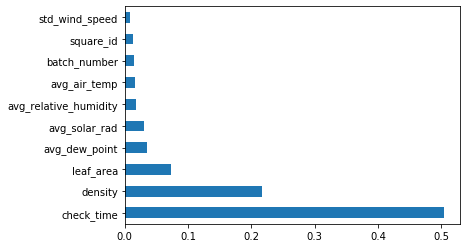

In [137]:
feat_importances = pd.Series(model.feature_importances_, index=plant.iloc[:, 3:-5].columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.savefig("feature_imp_all.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [138]:
# Model 2.1 : Random Forest using just plant data
model = RandomForestRegressor()
model.fit(X_plant_train, y_plant_train)
y_pred = model.predict(X_plant_test)
print('model score:' ,r2_score(y_plant_test, y_pred, multioutput='variance_weighted'))

model score: 0.9232030266163006


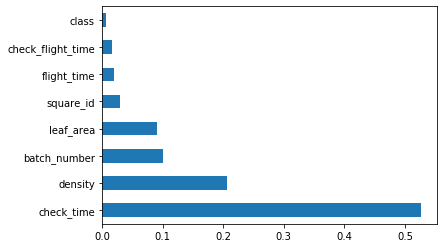

In [140]:
feat_importances = pd.Series(model.feature_importances_, index=plant.iloc[:, 3:11].columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.savefig("feature_imp_plant.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [141]:
# Model 2.2 : Random Forest using just weather data
model = RandomForestRegressor()
model.fit(X_weather_train, y_weather_train)
y_pred = model.predict(X_weather_test)
print('model score:' ,r2_score(y_weather_test, y_pred, multioutput='variance_weighted'))

model score: 0.6233960500447456


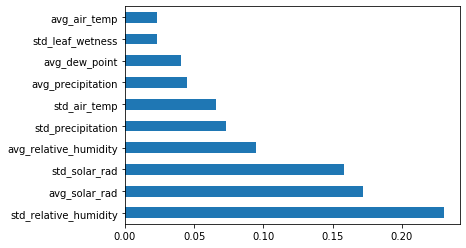

In [142]:
feat_importances = pd.Series(model.feature_importances_, index=plant.iloc[:, 11:25].columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.savefig("feature_imp_weather.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [94]:
# list(plant.iloc[:, 3:-5].columns.values)

In [93]:
# Model 2 : Random Forest
model = RandomForestRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('model score:' ,r2_score(y_test, y_pred, multioutput='variance_weighted'))

model score: 0.9268413779437495


In [ ]:
# 'batch_number' ,'density' , 'leaf_area' , 'check_time', 'std_precipitation', 'avg_solar_rad',
#  'std_solar_rad', 'std_air_temp', 'avg_relative_humidity', 'std_relative_humidity', 'avg_dew_point', 
#     'std_dew_point'

In [91]:
# Model 3 : Gradient Boosting

reg = MultiOutputRegressor(GradientBoostingRegressor())
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.8931245007386255